In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from tqdm import tqdm
from dataclasses import dataclass
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
with open('../DATA/input.txt','r',encoding='utf-8') as f:
    text = f.read()
vocab = sorted(list(set(text)))
vocab
vocab_size = len(vocab)
vocab_size
stoi = {ch:i for i,ch in enumerate(vocab)}
itos = {i:ch for i,ch in enumerate(vocab)}
encode    = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
data = torch.tensor(encode(text),dtype=torch.long)

#data loading 
def get_batch(config):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(data) - config.block_size, (config.batch_size,))
    x = torch.stack([data[i:i+config.block_size] for i in ix])
    y = torch.stack([data[i+1:i+config.block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
"""Introducing bite-pair encoding to inc vocab_size"""
class TOkenizer:
    def __init__(self,Text,vocab_size = 84):
        self.Text = Text 
        self.tokens = list(map(int,self.Text))
        self.num_merges = vocab_size - 65
        self.merges = {}
        for i in range(self.num_merges):
            stats = self.get_stats(self.tokens)
            pair = max(stats,key=stats.get)
            idx = 65 + i
            self.tokens = self.merge(self.tokens,pair,idx)
            self.merges[pair] = idx            
    def merge(self,ids,pair,idx):
        newids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                newids.append(idx)
                i += 2
            else:
                newids.append(ids[i])
                i += 1
        return newids
    def get_stats(self,ids = None):
        if ids is None :
            ids = self.tokens
        counts = {}
        for pair in zip(ids,ids[1:]):
            counts[pair] = counts.get(pair,0) + 1
        return counts   
    def encode(self,text):
        pass
    def decode(self,ids):
        tokens = b"".join(vocab[idx] for idx in ids)
        text = tokens.decode('utf-8',errors='replace')
        return text
        

In [4]:
class DataLoader:
    def __init__(self,B,T):
        self.B = B
        self.T = T
        with open('../DATA/input.txt', 'r', encoding='utf-8') as f:
            text = f.read()
        tokens = encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens)//(B*T)} batches ')
        # state
    def __len__(self):
        return len(self.tokens)
    def next_batch(self):
        B,T = self.B,self.T
        starting_point = torch.randint(0,(len(self.tokens) - T - 1),(1,)).item()
        # starting from startpoint we sample B consective batches of length T, and if we got out of bound we use kinda circular approach
        idxs = torch.arange(starting_point,starting_point + B*T + 1)% len(self.tokens)
        buf = self.tokens[idxs].clone()
        x = buf[:-1].view(B,T) 
        y = buf[1:].view(B,T)
        return x,y

In [5]:
@dataclass
class GRUconfig:
    vocab_size :int = 65
    n_embd :int = 384
    block_size :int = 256
    c_size :int = 512  # will act as dim of the hidden-memory
    batch_size :int = 512#2048#1024*2


class GRU(nn.Module):
    """
    we will we having 2 gates r(reset gate) and u(update gate)
    reset gate will decide what part of the previous state has to be transfered to the current hidden state
    and update gate decides the ratio between the previous information and current hidden state information 
    has to be passed to the current memory.
    self._c refers to the ~c<t> which is candidate hidden memory
    """
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.embd = nn.Embedding(self.config.vocab_size,self.config.n_embd) # Embedding matrix
        self.r = nn.Linear(in_features=self.config.c_size + self.config.n_embd,out_features=self.config.c_size)
        self.u = nn.Linear(in_features=self.config.c_size + self.config.n_embd,out_features=self.config.c_size)
        self._c = nn.Linear(in_features=self.config.c_size + self.config.n_embd,out_features=self.config.c_size)
        self.Wy = nn.Linear(self.config.c_size,self.config.vocab_size)
        self.sigmoid = torch.sigmoid
        self.dropout = nn.Dropout(0.2)

    def forward(self,x,c0=None):

        # we have to make sure x has dim(batch_size,block_size)
        B,T = x.shape
        if c0 is None:
            c0 = torch.zeros(B,self.config.c_size,device=device) # intial memory as zero vector with No bias 
        """Broadcasting will take care of batch dim"""
        x = self.embd(x) # introduces a extra dim (batch_size,T,n_embd)
        output = []
        for i in range(T):
            x_t = x[:,i,:] #ith token from each batch  (B,n_embd)
            x_t = self.dropout(x_t)
            #unified input to the gates
            unified_input = torch.cat((c0,x_t),dim=1)  # (B, c_size + n_embd)
            # shouldn't add dropout to the unified input as it disrupts the input to the gates
            # Gates 
            reset = self.sigmoid(self.r(unified_input)) # (B,c_size)
            update = self.sigmoid(self.u(unified_input)) # (B,c_size)
            # Candidate hidden state
            candidate = F.gelu(self._c(torch.cat((c0*reset,x_t),dim=1)))  # (B,c_size)
            
            # Candidate memory with skip connection
            current_memory = update*candidate + (1 - update)*c0
            c0 = current_memory # updated memory 
                    
            current_memory = self.dropout(current_memory)
            y = self.Wy(current_memory)
            output.append(y)
        logits = torch.stack(output,dim=1)
        return logits,c0
    def Generate(self,idx,new_tokens = 500):
        # we expect a batch of input as a list of tokens
        """ 
        if initial token is null --> we are good to go with that
        else if initial token isn't null --> what we do is, firstly we will
        feed these tokens to the network and let it update the hidden memory and
        atlast we just need the last tokken and last memory which will act as the a0

        we generate new tokens we append them to the existing token and then use the last genrated token as 
        the next char
        """
        self.eval()
        for _ in range(new_tokens):
            idx_cond = idx[:,-self.config.block_size:]  # selecting the newest block_size tokkens to generate the next tokken
            logits,memory = self(idx_cond) #this will generate the all outputs and memory, but we just need the last logit
            logits = logits[:,-1,:] # (Batch_size,vocab_size)
            # now we need to apply the softmax or eqivalent of the softmax
            probs = F.softmax(logits,dim=1)
            idx_next = torch.multinomial(probs,num_samples=1) #(B,1)
            #append it to the end
            idx = torch.cat((idx,idx_next),dim=1)
        return idx

        
            





        

In [6]:

default_config = GRUconfig()
model = GRU(default_config)
model.to(device=device)
# model.embd.weight.requires_grad = False
print(model.embd.weight.requires_grad)  # Should print: False

train_loader = DataLoader(default_config.batch_size,default_config.block_size)
len(train_loader)

True
loaded 1115394 tokens
1 epoch = 8 batches 


1115394

In [7]:
optimizer = torch.optim.AdamW( [param for param in model.parameters() if param.requires_grad],lr=1e-3,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [8]:
import os
save_dir = "GRU_checkpoints"
os.makedirs(save_dir, exist_ok=True)


In [9]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=50)


In [10]:
# optimizer.param_groups[0]['betas'] = (0.6,0.97)
# optimizer.param_groups[0]['lr'] = 1e-6

In [ ]:

# checkpoint = os.path.join(save_dir, "checkpoint499.pt")
# Draft = torch.load(checkpoint)
# model.load_state_dict(Draft['model_state_dict'])
# optimizer.load_state_dict(Draft['optimizer_state_dict'])

In [ ]:
num_epochs = 500
pbar = tqdm(range(num_epochs),desc="Training")
lossi = []
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
for epoch in pbar:
    x,y = train_loader.next_batch()
    x,y = x.to(device),y.to(device)
    logits,_ = model(x)
    B,T,C = logits.shape
    logits = logits.view(B*T,-1)
    y = y.view(-1)
    loss = criterion(logits,y)
    lossi.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Step the scheduler
    scheduler.step()
    torch.cuda.empty_cache()
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        pbar.set_postfix({"loss": loss.item()})
        
#Save the final model checkpoint
final_checkpoint_path = os.path.join(save_dir, f"checkpoint{epoch}.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, final_checkpoint_path)
print(f"Final model saved to {final_checkpoint_path}")  


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training: 100%|██████████| 500/500 [24:06<00:00,  2.89s/it, loss=1.48]

Final model saved to GRU_checkpoints\checkpoint499.pt


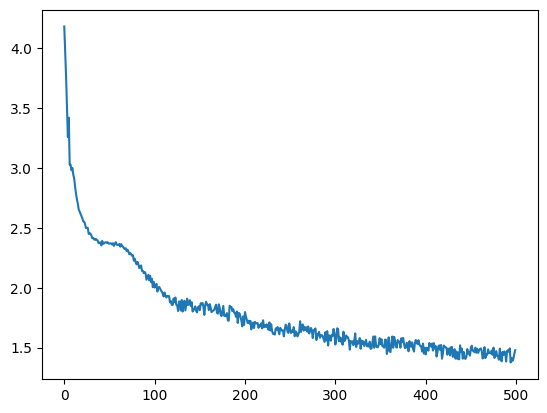

In [ ]:
plt.plot(lossi)

In [14]:
# Sampling example
txt = '''Servant: 
Where is thus; sweet so far courtainsried, '''
tok = encode(txt)
tok = torch.tensor(tok,dtype=torch.long,device=device).reshape(1,-1)
idx = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = model.Generate(idx,500)
print(f"Generated text:\n{txt}", decode(generated_text[0].tolist()))



Generated text:
Servant: 
Where is thus; sweet so far courtainsried,  
Do mean you with your hand.

LUCIO:
I'll report you from such a profect live,
She hath roth he made to give me down.

Whereiney Murderer:
Were now drom thy mother! be?

QUEEN MARGARET:
Where, you sound's matting hear life and tame up am a dictions?
Procose ears daughter on that: Comif our prant:
Nay, I guen duked, 'tis turn; he weeps!
Who say O, most tritmes, not be people.
Gone voice, be eachly truth the faint, for our scorn repent to with their honour should
for miney request of my dear.

CORI


In [13]:
open('more.txt', 'w').write(decode(model.Generate(idx,1000)[0].tolist()))

1001